## Here we'll try to replicate the results of Venturelli et al, measuring butyrate production in synthetically constructed _in vitro_ communities. We'll hope to see that predictions of butyrate production from MICOM constructed community models accurately reflect the measured butyrate production from the experiments. 

In [1]:
import os
import pandas as pd
from plotnine import *
from tqdm import tqdm
import numpy as np
import scipy
import micom
import micom.measures

%matplotlib inline

## Function for building our taxonomies, which accepts an abundance dataframe of taxonomic fractions measured in the experiments. 

In [ ]:
def build_table(taxa):
    #first, define an empty taxonomy dataframe, which we will use to build models
    taxonomy = pd.DataFrame()
    #we'll iterate through the taxonomic data provided, and append individual taxonomic abundances to our taxonomy table
    for x in tqdm(taxa.index): 
        #find the row corresponding to the sample of interest in the abundance dataframe
        sample = taxa.loc[x].index.to_list()
        #isolate the genera abbreviations, and put into a list
        names = ",".join([x[:2] for x in sample]).split(',')
        #now we map the abbreviations to the file list (see next cell) to find the GSMs for each 
        file = list(map(genera.get,names))
        #now we'll put together a pandas Series to concatenate with the taxonomy table
        sample_taxa = pd.DataFrame({ 
            "id": names, #genus abbreviations 
            "abundance":taxa.loc[x], #genus abundances
            "file": file, #genus JSON file
            "sample_id":x}) #sample ID
        sample_taxa = sample_taxa.dropna(how = 'any') #drop any rows with empty values
        taxonomy = pd.concat([taxonomy,sample_taxa]) #concate the series onto the taxonomy table
    return taxonomy

## Let's start by initializing our dictionary of genera abbreviations, since the taxa are given by two letter abbreviations in the abundance dataframe. The taxa in the experiement are given at the species level, but for consistency we will build models at the genus level. Therefore, some duplicates will be seen in this dict

In [ ]:
genera = {'PC':'Prevotella.json',
          'PJ':'Parabacteroides.json',
          'BV':'Bacteroides.json',
          'BF':'Bacteroides.json',
          'BO':'Bacteroides.json',
          'BT':'Bacteroides.json',
          'BC':'Bacteroides.json',
          'BY':'Bacteroides.json',
          'BU':'Bacteroides.json',
          'DP':'Desulfovibrio.json',
          'BL':'Bifidobacterium.json',
          'BA':'Bifidobacterium.json',
          'BP':'Bifidobacterium.json',
          'CA':'Collinsella.json',
          'EL':'Eggerthella.json',
          'FP':'Faecalibacterium.json',
          'CH':'Clostridium.json',
          'AC':'Anaerostipes.json',
          'BH':'Blautia.json',
          'CG':'Clostridium.json',
          'ER':'Eubacterium.json',
          'RI':'Roseburia.json',
          'CC':'Coprococcus.json',
          'DL':'Dorea.json',
          'DF':'Dorea.json'}

## Let's pull up the primary dataframe with abundances, ODs, and SCFAs. This can be found at https://github.com/RyanLincolnClark/DesignSyntheticGutMicrobiomeAssemblyFunction/commonfiles


In [3]:
#read in the dataframe
main = pd.read_csv('../data/invitro_data.csv',index_col=0) #get the dataframe
#drop HB - abbreviation not given in manuscript
main = main.drop(columns = 'HB')
#for columns 11:37, which represent binary presence/absence as a 1 or 0 for each species, we fill in zeros for NAs. 
main[main.columns[11:37]] = main[main.columns[11:37]].fillna(0).astype('int')
#we can calculate richness of each sample by summing these presence/absence numbers
main['richness'] = main[main.columns[11:37]].sum(axis = 1)
#also isolate the plate, column, and run ID for each row. These will serve as sample IDs for each individual sample
main['Plate'] = main['Plate'].astype('str').str.split('.').str[0].apply(lambda x: x.zfill(2))
main['Column'] = main['Column'].astype('str').str.split('.').str[0].apply(lambda x: x.zfill(2))
main['Run'] = main['Sequencing Run'].str[-3:]
#designate the sample ID
main['sample_id'] = 'P'+main['Plate']+main['Row']+main['Column']+'_'+main['Run']
#remove any samples that have contamination
main = main[main['Contamination?']=='No']
#set the index as the sample ID
main.set_index('sample_id',inplace = True)
main = main[~main.index.duplicated(keep = 'last')]

## Let's also pull up the componentized diet dataframe

In [4]:
#load the medium
medium = pd.read_csv('../media/DM38.csv')
medium

,index,reaction,flux
0,EX_cl_m,EX_cl_m,4.300000
1,EX_ca2_m,EX_ca2_m,1.290106
2,EX_cu2_m,EX_cu2_m,0.010000
3,EX_so4_m,EX_so4_m,10.000000
4,EX_pydx_m,EX_pydx_m,0.009822
...,...,...,...
58,EX_arab_L_m,EX_arab_L_m,21.314860
59,EX_glc_D_m,EX_glc_D_m,24.978352
60,EX_lac_L_m,EX_lac_L_m,28.308171
61,EX_malt_m,EX_malt_m,4.382121


## Now we'll start with the low richness (1-5 species) communities

In [5]:
#isolate table to low richness
low = main[(main['richness'].astype('int') <=5)] 
#now let's isolate those columns that have fractional abundance of taxa
taxa_low = [cols for cols in low.columns if 'Fraction' in cols] #df with the taxa present in each community
#drop B.cereus - not included in paper
taxa_low = low[taxa_low].drop(columns = ['B.cereus Fraction'])
#isolate the optical density and measured butyrate of each sample and convert to a dict for future use
OD_low = low['OD'].to_dict()
meas_but_low = low['Butyrate'].to_dict()

### Build the models for low richness communities

In [ ]:
os.chdir('../agora/data')
#use the build table function to construct a taxonomy table
taxonomy = build_table(taxa_low) 
#build the models from the taxonomy table with a cutoff of 0.001
manifest_low = micom.workflows.build(taxonomy, out_folder='../../models/invitro/low_richness',
                                  model_db = None, cutoff=0.001, threads=10)

#model_db equals none since we have included the file path for each GSM in the taxonomy table

### Now that they are built, let's grow the low richness models with our DM38 medium

In [10]:
#Read the manifest produced above
manifest_low = pd.read_csv('../models/invitro/low_richness/manifest.csv')
#grow the models, using the medium and a tradeoff value of 0.7
growth = micom.workflows.grow(manifest_low,'../models/invitro/low_richness',medium,
                           tradeoff = 0.7, threads = 10)
#isolate exchanges, and multiply the fluxes by abundances for absolute production
exchanges = micom.measures.production_rates(growth)
but_low = exchanges[exchanges.reaction.str.startswith('EX_but(e)')].rename(columns = {'flux':'predicted'})
#map the optical density of each sample onto the dataframe
but_low['OD'] = but_low['sample_id'].map(OD_low)
#scale the measured value by the optical density as a proxy for flux per dry cell weight
but_low['measured'] = but_low['sample_id'].map(meas_but_low)/but_low['OD']
#scaling can lead to inaccurately low levels due to low OD - remove outlier points
but_low = but_low[but_low['measured']>0]
but_low = but_low[but_low['measured']<100]

Output()

/users/nbohmann/.local/lib/python3.8/site-packages/micom/workflows/grow.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


### Plot results for low richness communities

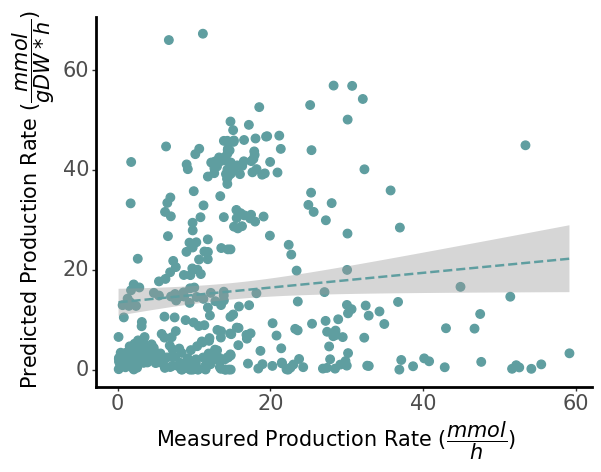

<ggplot: (8744738287770)>

In [11]:
plt = ( #plot scaled measured value vs predicted value for butyrate flux
    ggplot(
    but_low, aes(x = 'measured',y = 'predicted'))
    +geom_point(size = 3, color = 'cadetblue')
    +geom_smooth(method = 'lm', color = 'cadetblue',linetype =  '--')
    +labs(x = 'Measured Production Rate ($\dfrac{mmol}{h}$)', y = 'Predicted Production Rate ($\dfrac{mmol}{gDW*h}$)')
    +theme(text = element_text(size=15),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),
                                panel_grid=element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_title=element_blank(),
                                legend_position='right'))
plt

### Use Pearson correlation to test relationship between measured and predicted values

In [ ]:
rho, p = scipy.stats.pearsonr(but_low['measured'], but_low['predicted'])
p

## We'll repeat this for high richness models, with 11-25 taxa per community

In [ ]:
#filter to high richness
high = main[(main['richness'].astype('int')>=10)] 
#get fractional abundances
taxa_high = [cols for cols in high.columns if 'Fraction' in cols] 
#drop b. cereus
taxa_high = high[taxa_high].drop(columns = ['B.cereus Fraction'])
#create dicts for optical density, butyrate
OD_high = high['OD'].to_dict()
meas_but_high = high['Butyrate'].to_dict()

### Build the models for high richness communities

In [ ]:
#build the taxonomy table using the build_table function
taxonomy = build_table(taxa_high)
#build models with a cutoff of 0.001
manifest_high = micom.workflows.build(taxonomy, out_folder='../../models/invitro/high_richness',
                                  model_db = None, cutoff=0.001, threads=20)

### Grow the models for high richness communities

In [ ]:
#load the manifest for the high richness communities
manifest_high = pd.read_csv('../../models/invitro/high_richness/manifest.csv')
#grow the models, using the medium and a tradeoff value of 0.7
growth = micom.workflows.grow(manifest_low,'../../models/invitro/high_richness',medium,
                           tradeoff = 0.7, threads = 10)
exchanges = micom.measures.production_rates(growth)
but_high = exchanges[exchanges.reaction.str.startswith('EX_but(e)')].rename(columns = {'flux':'predicted'})
but_high['OD'] = but_high['sample_id'].map(OD_high)
but_high['measured'] = but_high['sample_id'].map(meas_but_high)/but_high['OD']

### Plot High Richness Results

In [ ]:
plt = ( #plot scaled measured value vs predicted value for butyrate flux
    ggplot(
    but_high, aes(x = 'measured',y = 'predicted'))
    +geom_point(size = 3, color = "cadetblue")
    +geom_smooth(method = 'lm', color = "cadetblue", linetype = '--')
    +labs(x = 'Measured Production Rate ($\dfrac{mmol}{h}$)', y = 'Predicted Production Rate ($\dfrac{mmol}{gDW*h}$)')
    +theme(text = element_text(size=20),panel_background=element_rect(fill = "white",
                                colour = "white",size = 0.5, linetype = "solid"),panel_grid= element_blank(),
                                axis_line = element_line(size = 2, linetype = "solid",colour = "black"),
                                legend_title=element_blank(),
                                legend_position='right'))
plt

### Use Pearson correlation to test relationship between measured and predicted values

In [ ]:
#Check the pearson correlation statistics
rho, p = scipy.stats.pearsonr(but_high['measured'], but_high['predicted'])
p

## Save the resulting dataframes for low and high richness communities for use in building the final figures

In [ ]:
but_low.to_csv('../results/invitro_low.csv')
but_high.to_csv('../results/invitro_high.csv')